# Explaining Keras image classifier predictions with Grad-CAM

If we have a model that takes in an image as its input, and outputs class scores, i.e. probabilities that a certain object is present in the image, then we can use ELI5 to check what is it in the image that made the model predict a certain class score. We do that using a method called 'Grad-CAM' (https://arxiv.org/abs/1610.02391).

We will be using images from ImageNet (http://image-net.org/), and classifiers from `keras.applications`. 

This has been tested with Python 3.12.9, Keras 3.9.2, and Tensorflow 2.19.0.

## 1. Loading our model and data

To start out, let's get our modules in place

In [12]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

And load our image classifier (a light-weight model from `keras.applications`).

In [2]:
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

(None, 224, 224, 3)
(224, 224)


We see that we need a numpy tensor of shape (batches, height, width, channels), with the specified height and width.

Loading our sample image:

<class 'PIL.JpegImagePlugin.JpegImageFile'>


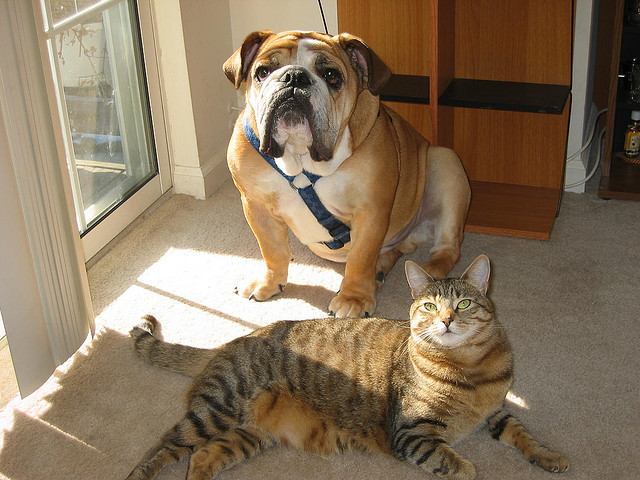

In [3]:
# we start from a path / URI. 
# If you already have an image loaded, follow the subsequent steps
image_uri = 'imagenet-samples/cat_dog.jpg'

# this is the original "cat dog" image used in the Grad-CAM paper
# check the image with Pillow
im = Image.open(image_uri)
print(type(im))
display(im)

We see that this image will need some preprocessing to have the correct dimensions! Let's resize it:

<PIL.Image.Image image mode=RGB size=224x224 at 0x15CFEC4A0>


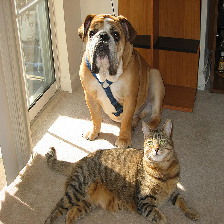

In [4]:
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
im = keras.preprocessing.image.load_img(image_uri, target_size=dims) # -> PIL image
print(im)
display(im)

Looking good. Now we need to convert the image to a numpy array.

In [5]:
# we use a routine from `keras.preprocessing` for that as well
# we get a 'doc', an object almost ready to be inputted into the model

doc = keras.preprocessing.image.img_to_array(im) # -> numpy array
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [6]:
# dimensions are looking good
# except that we are missing one thing - the batch size

# we can use a numpy routine to create an axis in the first position
doc = np.expand_dims(doc, axis=0)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


In [7]:
# `keras.applications` models come with their own input preprocessing function
# for best results, apply that as well

# mobilenetv2-specific preprocessing
# (this operation is in-place)
mobilenet_v2.preprocess_input(doc)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


Let's convert back the array to an image just to check what we are inputting

<PIL.Image.Image image mode=RGB size=224x224 at 0x15CD8C980>


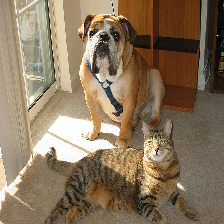

In [8]:
# take back the first image from our 'batch'
image = keras.preprocessing.image.array_to_img(doc[0])
print(image)
display(image)

Ready to go!

## 2. Explaining our model's prediction

Let's classify our image and see where the network 'looks' when making that classification:

In [9]:
# make a prediction about our sample image
predictions = model.predict(doc)
print(type(predictions), predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
<class 'numpy.ndarray'> (1, 1000)


In [10]:
# check the top 5 indices
# `keras.applications` contains a function for that

top = mobilenet_v2.decode_predictions(predictions)
top_indices = np.argsort(predictions)[0, ::-1][:5]

print(top)
print(top_indices)

[[('n02108422', 'bull_mastiff', np.float32(0.8096749)), ('n02108089', 'boxer', np.float32(0.09835984)), ('n02123045', 'tabby', np.float32(0.0066503943)), ('n02123159', 'tiger_cat', np.float32(0.004808728)), ('n02110958', 'pug', np.float32(0.003941001))]]
[243 242 281 282 254]


Indeed there is a dog in that picture The class ID (index into the output layer) `243` stands for `bull mastiff` in ImageNet with 1000 classes (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a ). 

But how did the network know that? Let's check where the model "looked" for a dog with ELI5:

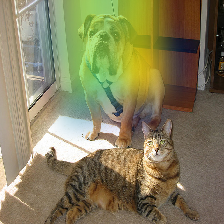

In [13]:
# we need to pass the network
# the input as a numpy array
eli5.show_prediction(model, doc)

The dog region is highlighted. Makes sense!

When explaining image based models, we can optionally pass the image associated with the input as a Pillow image object. If we don't, the image will be created from ``doc``. This may not work with custom models or inputs, in which case it's worth passing the image explicitly.

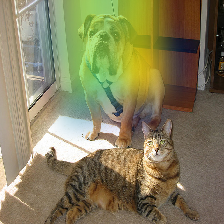

In [14]:
eli5.show_prediction(model, doc, image=image)

## 3. Choosing the target class (target prediction)

We can make the model classify other objects and check where the classifier looks to find those objects.

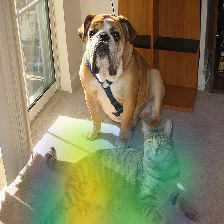

In [15]:
cat_idx = 282 # ImageNet ID for "tiger_cat" class, because we have a cat in the picture
eli5.show_prediction(model, doc, targets=[cat_idx]) # pass the class id

The model looks at the cat now!

We have to pass the class ID as a list to the `targets` parameter. Currently only one class can be explained at a time.

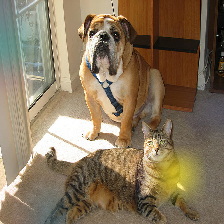

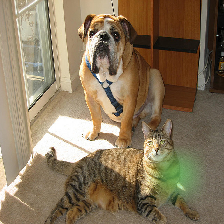

In [16]:
window_idx = 904 # 'window screen'
turtle_idx = 35 # 'mud turtle', some nonsense
display(eli5.show_prediction(model, doc, targets=[window_idx]))
display(eli5.show_prediction(model, doc, targets=[turtle_idx]))

That's quite noisy! Perhaps the model is weak at classifying 'window screens'! On the other hand the nonsense 'turtle' example could be excused.


Note that we need to wrap `show_prediction()` with `IPython.display.display()` to actually display the image when `show_prediction()` is not the last thing in a cell.

## 4. Choosing a hidden activation layer

Under the hood Grad-CAM takes a hidden layer inside the network and differentiates it with respect to the output scores. We have the ability to choose which hidden layer we do our computations on.

Let's check what layers the network consists of, printing the first few and the last few layers:

In [24]:
model.summary(layer_range=['input_layer', 'Conv1_relu'], line_length=100)
model.summary(layer_range=['block_16_depthwise_relu', 'predictions'], line_length=100)

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1 (Conv2D)              │ (None, 112, 112, 32)    │            864 │ input_layer[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_Conv1                    │ (None, 112, 112, 32)    │            128 │ Conv1[0][0]             │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1_relu (ReLU)           │ (None, 112, 112, 32)    │              0 │ bn_Conv1[0][0]          │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ block_16_depthwise_relu     │ (None, 7, 7, 960)       │              0 │ block_16_depthwise_BN[… │
│ (ReLU)                      │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block_16_project (Conv2D)   │ (None, 7, 7, 320)       │        307,200 │ block_16_depthwise_rel… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block_16_project_BN         │ (None, 7, 7, 320)       │          1,280 │ block_16_project[0][0]  │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv_1 (Conv2D)             │ (None, 7, 7, 1280)      │        409,600 │ block_16_project_BN[0]… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Conv_1_bn                   │ (None, 7, 7, 1280)      │          5,120 │ Conv_1[0][0]            │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ out_relu (ReLU)             │ (None, 7, 7, 1280)      │              0 │ Conv_1_bn[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ global_average_pooling2d    │ (None, 1280)            │              0 │ out_relu[0][0]          │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ predictions (Dense)         │ (None, 1000)            │      1,281,000 │ global_average_pooling… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Let's pick a few convolutional layers that are 'far apart' and do Grad-CAM on them:

block_2_expand


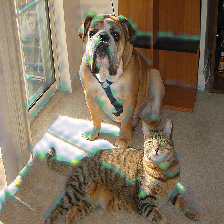

block_9_expand


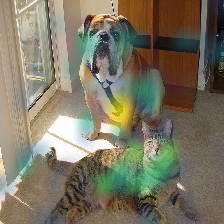

Conv_1


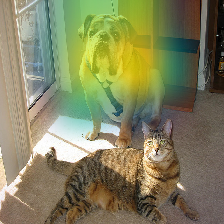

In [25]:
for l in ['block_2_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument

These results should make intuitive sense for Convolutional Neural Networks. Initial layers detect 'low level' features, ending layers detect 'high level' features!

The `layer` parameter accepts a layer instance, index, name, or None (get layer automatically) as its arguments. This is where Grad-CAM builds its heatmap from.

## 5. Under the hood - `explain_prediction()` and `format_as_image()`

This time we will use the `eli5.explain_prediction()` and `eli5.format_as_image()` functions (that are called one after the other by the convenience function `eli5.show_prediction()`), so we can better understand what is going on.

In [26]:
expl = eli5.explain_prediction(model, doc)

Examining the structure of the `Explanation` object:

In [27]:
print(expl)

Explanation(estimator='mobilenetv2_1.00_224', description='Grad-CAM visualization for image classification; \noutput is explanation object that contains input image \nand heatmap image for a target.\n', error='', method='Grad-CAM', is_regression=False, targets=[TargetExplanation(target=243, feature_weights=None, proba=None, score=0.8096752166748047, weighted_spans=None, heatmap=array([[0.        , 0.34700352, 0.81830257, 0.80335682, 0.90060196,
        0.11643584, 0.01095215],
       [0.01533248, 0.3834124 , 0.80703724, 0.85117104, 0.95316517,
        0.28513848, 0.        ],
       [0.00708034, 0.20260012, 0.77189809, 0.77733623, 0.99999865,
        0.30238799, 0.        ],
       [0.        , 0.04289391, 0.44958652, 0.3008664 , 0.25115574,
        0.06772013, 0.        ],
       [0.01483664, 0.        , 0.        , 0.        , 0.        ,
        0.0057982 , 0.01929006],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.05308538],
       [0.   

We can check the score (raw value) or probability (normalized score) of the neuron for the predicted class, and get the class ID itself:

In [28]:
# we can access the various attributes of a target being explained
print((expl.targets[0].target, expl.targets[0].score, expl.targets[0].proba))

(243, 0.8096752166748047, None)


We can also access the original image and the Grad-CAM heatmap:

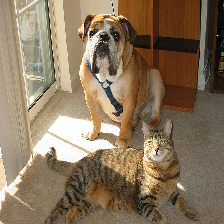

[[0.         0.34700352 0.81830257 0.80335682 0.90060196 0.11643584
  0.01095215]
 [0.01533248 0.3834124  0.80703724 0.85117104 0.95316517 0.28513848
  0.        ]
 [0.00708034 0.20260012 0.77189809 0.77733623 0.99999865 0.30238799
  0.        ]
 [0.         0.04289391 0.44958652 0.3008664  0.25115574 0.06772013
  0.        ]
 [0.01483664 0.         0.         0.         0.         0.0057982
  0.01929006]
 [0.         0.         0.         0.         0.         0.
  0.05308538]
 [0.         0.         0.         0.         0.         0.01124753
  0.06864622]]


In [29]:
image = expl.image
heatmap = expl.targets[0].heatmap

display(image) # the .image attribute is a PIL image
print(heatmap) # the .heatmap attribute is a numpy array

Visualizing the heatmap:

In [30]:
heatmap_im = eli5.formatters.image.heatmap_to_image(heatmap)
display(heatmap_im)

That's only 7x7! This is the spatial dimensions of the activation/feature maps in the last layers of the network. What Grad-CAM produces is only a rough approximation.

Let's resize the heatmap (we have to pass the heatmap and the image with the required dimensions as Pillow images, and the filter for resampling):

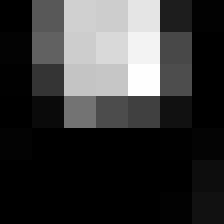

In [31]:
heatmap_im = eli5.formatters.image.expand_heatmap(heatmap, image, resampling_filter=Image.BOX)
display(heatmap_im)

Now it's clear what is being highlighted. We just need to apply some colors and overlay the heatmap over the original image, exactly what `eli5.format_as_image()` does!

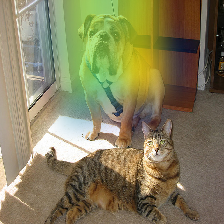

In [32]:
I = eli5.format_as_image(expl)
display(I)

## 6. Extra arguments to `format_as_image()`

`format_as_image()` has a couple of parameters too:

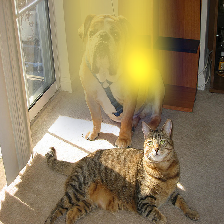

In [33]:
import matplotlib.cm

I = eli5.format_as_image(expl, alpha_limit=1.0, colormap=matplotlib.cm.cividis)
display(I)

The `alpha_limit` argument controls the maximum opacity that the heatmap pixels should have. It is between 0.0 and 1.0. Low values are useful for seeing the original image.

The `colormap` argument is a function (callable) that does the colorisation of the heatmap. See `matplotlib.cm` for some options. Pick your favourite color!

Another optional argument is `resampling_filter`. The default is `PIL.Image.LANCZOS` (shown here). You have already seen `PIL.Image.BOX`.

## 7. Removing softmax

The original Grad-CAM paper (https://arxiv.org/pdf/1610.02391.pdf) suggests that we should use the output of the layer before softmax when doing Grad-CAM (use raw score values, not probabilities). Currently ELI5 simply takes the model as-is. Let's try and swap the softmax (logits) layer of our current model with a linear (no activation) layer, and check the explanation:

with softmax


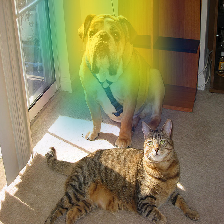

without softmax


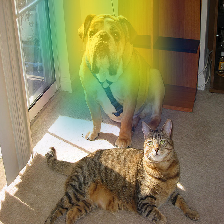

In [36]:
# first check the explanation *with* softmax
print('with softmax')
display(eli5.show_prediction(model, doc))


# remove softmax
l = model.get_layer(index=-1) # get the last (output) layer
l.activation = keras.activations.linear # swap activation

# save and load back the model as a trick to reload the graph
model.save('tmp_model_save_rmsoftmax.keras') # note that this creates a file of the model
model = keras.models.load_model('tmp_model_save_rmsoftmax.keras')

print('without softmax')
display(eli5.show_prediction(model, doc))

We see some slight differences. The activations are brighter. Do consider swapping out softmax if explanations for your model seem off.

## 8. Comparing explanations of different models

According to the paper at https://arxiv.org/abs/1711.06104, if an explanation method such as Grad-CAM is any good, then explaining different models should yield different results. Let's verify that by loading another model and explaining a classification of the same image:

mobilenetv2_1.00_224


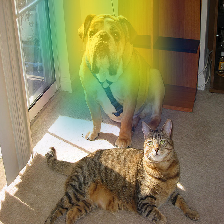

NASNet


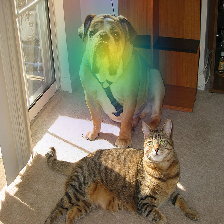

In [26]:
from keras.applications import nasnet

model2 = nasnet.NASNetMobile(include_top=True, weights='imagenet', classes=1000)

# we reload the image array to apply nasnet-specific preprocessing
doc2 = keras.preprocessing.image.img_to_array(im)
doc2 = np.expand_dims(doc2, axis=0)
nasnet.preprocess_input(doc2)

print(model.name)
# note that this model is without softmax
display(eli5.show_prediction(model, doc))
print(model2.name)
display(eli5.show_prediction(model2, doc2))

Wow `show_prediction()` is so robust!